In [1]:
import os  # noqa
import sys  # noqa

proj_root = os.path.dirname(os.getcwd())
sys.path.append(proj_root)

OBJ_NAME = "mustard_bottle"
VIDEO_NAME = "mustard0"


video_dir = os.path.join(proj_root, "data", "inputs", VIDEO_NAME)
poses_dir = os.path.join(video_dir, "annotated_poses")
cam_K_dir = os.path.join(video_dir, "cam_K.txt")
obj_dir = os.path.join(proj_root, "data", "objects", OBJ_NAME)

In [2]:
import glob

from tqdm import tqdm
from posingpixels.utils.offscreen_renderer import ModelRendererOffscreen
import cv2
import numpy as np
import trimesh
import matplotlib.pyplot as plt
from posingpixels.utils.cotracker import sample_support_grid_points
from posingpixels.utils.geometry import interpolate_poses

from posingpixels.utils.meshes import get_diameter_from_mesh
from posingpixels.alignment import get_safe_query_points
from posingpixels.segmentation import segment
import torch
from cotracker.utils.visualizer import Visualizer
from posingpixels.cotracker import get_offline_cotracker_predictions
from posingpixels.cotracker import get_online_cotracker_predictions
from typing import Optional, Tuple
from posingpixels.segmentation import get_bbox_from_mask, process_image_crop
from typing import Tuple
from posingpixels.utils.cotracker import scale_by_crop

from posingpixels.utils.cotracker import get_ground_truths

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class YCBinEOATDataset(torch.utils.data.Dataset):
    def __init__(self, video_dir: str, object_dir: str):
        # Video
        self.video_dir = video_dir
        self.video_rgb_dir = os.path.join(self.video_dir, "rgb")
        self.rgb_video_files = sorted(glob.glob(f"{self.video_dir}/rgb/*.png"))
        self.gt_pose_dir = os.path.join(self.video_dir, "annotated_poses")
        self.gt_pose_files = sorted(glob.glob(f"{self.video_dir}/annotated_poses/*"))
        self.gt_mask_files = sorted(glob.glob(f"{self.video_dir}/gt_mask/*"))

        self.K = np.loadtxt(os.path.join(self.video_dir, "cam_K.txt")).reshape(3, 3)
        self.H, self.W = cv2.imread(self.rgb_video_files[0], cv2.IMREAD_COLOR).shape[:2]

        # Segmentation
        self.videoname_to_sam_prompt = {
            "mustard0": [(124, 292), (135, 304), (156, 336)]
        }
        self.masks_dir = os.path.join(self.video_dir, "masks")
        if not os.path.exists(self.masks_dir) or len(os.listdir(self.masks_dir)) == 0:
            segment(
                self.video_rgb_dir,
                self.masks_dir,
                prompts=self.videoname_to_sam_prompt[self.video_name],
            )
        self.mask_files = sorted(glob.glob(f"{self.masks_dir}/*.png"))

        # Object
        self.object_dir = object_dir
        self.obj_path = os.path.join(self.object_dir, "textured_simple.obj")
        mesh = self.get_mesh()
        self.obj_diameter = get_diameter_from_mesh(mesh)
        self.renderer = ModelRendererOffscreen(self.K, self.H, self.W)

        # Both
        self.videoname_to_object = {
            "bleach0": "bleach_cleanser",
            "bleach_hard_00_03_chaitanya": "bleach_cleanser",
            "cracker_box_reorient": "cracker_box",
            "cracker_box_yalehand0": "cracker_box",
            "mustard0": "mustard_bottle",
            "mustard_easy_00_02": "mustard_bottle",
            "sugar_box1": "sugar_box",
            "sugar_box_yalehand0": "sugar_box",
            "tomato_soup_can_yalehand0": "tomato_soup_can",
        }

    @property
    def video_name(self):
        return os.path.basename(self.video_dir)

    def __len__(self):
        return len(self.rgb_video_files)

    def get_mesh(self) -> trimesh.Trimesh:
        return trimesh.load_mesh(self.obj_path)

    @property
    def image_size(self):
        if self.H is None or self.W is None:
            self.H, self.W = cv2.imread(
                os.listdir(self.video_rgb_dir)[0], cv2.IMREAD_COLOR
            ).shape[:2]
        return self.H, self.W

    def get_gt_poses(self) -> np.ndarray:
        pose = None
        poses = []
        for i in range(len(self)):
            pose_i = self.get_gt_pose(i)
            pose = pose_i if pose_i is not None else pose
            poses.append(pose)
        return np.array(poses)

    def get_gt_pose(self, idx: int) -> Optional[np.ndarray]:
        file = os.path.join(self.gt_pose_dir, f"{idx:07d}.txt")
        if not os.path.exists(file):
            return None
        return np.loadtxt(file).reshape(4, 4)

    def get_rgb(self, idx: int) -> np.ndarray:
        return cv2.cvtColor(
            cv2.imread(self.rgb_video_files[idx], cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB
        )

    def get_mask(self, idx: int) -> np.ndarray:
        return cv2.imread(self.mask_files[idx], cv2.IMREAD_GRAYSCALE) / 255

    def get_gt_mask(self, idx: int) -> np.ndarray:
        return cv2.imread(self.gt_mask_files[idx], cv2.IMREAD_GRAYSCALE)

    def render_mesh_at_pose(
        self, pose: Optional[np.ndarray] = None, idx: Optional[int] = None
    ) -> Tuple[np.ndarray, np.ndarray]:
        assert (pose is None) != (idx is None)
        pose = self.get_gt_pose(idx) if pose is None else pose
        return self.renderer.render(pose, self.get_mesh())

    def get_canonical_pose(self):
        canonical_pose = np.eye(4)
        diameter = self.obj_diameter

        # Translate along z-axis by diameter
        canonical_pose[:3, 3] = np.array([0, 0, diameter])
        # Rotate 90 degrees around x-axis then rotate around y-axis 180 degrees
        canonical_pose[:3, :3] = np.array([[-1, 0, 0], [0, 0, -1], [0, -1, 0]])

        return canonical_pose

/home/joao/miniconda3/envs/gspose/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


tensor([[ 0.6202, -0.2515,  0.7436, -0.4486],
        [-0.7689, -0.3818,  0.5122,  0.1179],
        [ 0.1561, -0.8886, -0.4312,  0.8034],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
tensor([[319.5820,   0.0000, 320.2150],
        [  0.0000, 417.1187, 244.3487],
        [  0.0000,   0.0000,   1.0000]], device='cuda:0')


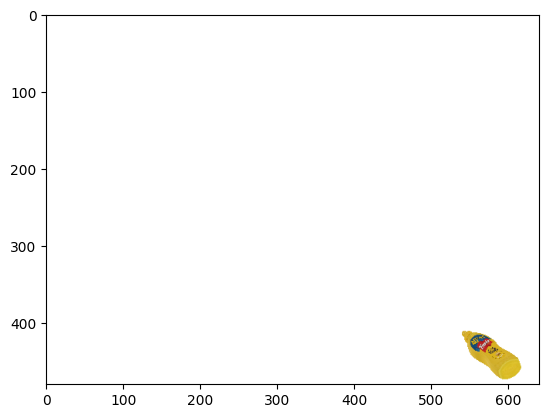

uint8 uint8


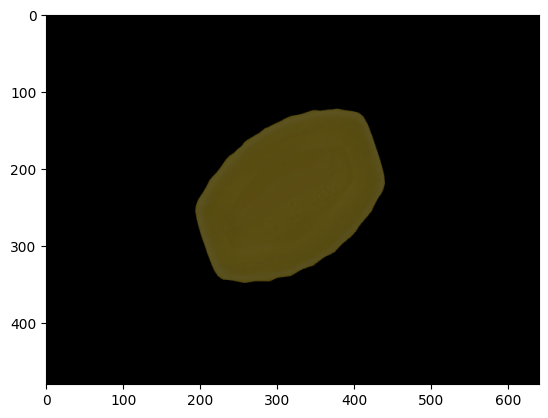

In [ ]:

import trimesh

import torch


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np
import torch
import torch.nn as nn
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.renderer import (
    PerspectiveCameras,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    AmbientLights,
)
from pytorch3d.structures import Meshes
from typing import NamedTuple
import glob
import matplotlib.pyplot as plt


# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)


class RenderOutput(NamedTuple):
    """Output type for render operations containing RGB and depth."""

    rgb: torch.Tensor
    depth: torch.Tensor


class BatchRenderer(nn.Module):
    """
    A class for efficient batch rendering of 3D meshes using PyTorch3D.
    Supports rendering the same mesh in multiple poses simultaneously.
    Returns both RGB and depth values.
    """

    def __init__(
        self,
        K: torch.Tensor,
        H: int,
        W: int,
        znear: float = 0.001,
        zfar: float = 100,
        device: torch.device = None,
    ):
        """
        Initialize the batch renderer.

        Args:
            K (torch.Tensor): 3x3 camera intrinsic matrix
            H (int): Render height in pixels
            W (int): Render width in pixels
            znear (float): Near clipping plane
            zfar (float): Far clipping plane
        """
        super().__init__()

        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.H = H
        self.W = W
        self.znear = znear
        self.zfar = zfar

        # Store camera intrinsics
        self.K = K.to(self.device)
        
        # Normalize focal length by image dimensions
        # fx is normalized by width, fy by height
        self.focal_length = torch.tensor([
            K[0, 0] / W,  # fx normalized
            K[1, 1] / H   # fy normalized
        ]).to(self.device) * 2
        
        # Normalize principal point to range [-1, 1]
        # First normalize by image dimensions to [0, 1], then transform to [-1, 1]
        self.principal_point = torch.tensor([
            2 * (K[0, 2] / W) - 1,  # px normalized
            2 * (K[1, 2] / H) - 1   # py normalized
        ]).to(self.device)
        
        # Set up rasterization settings
        self.raster_settings = RasterizationSettings(
            image_size=(H, W),
            blur_radius=0.0,
            faces_per_pixel=1,
            perspective_correct=True,
            clip_barycentric_coords=True,
        )
        
        # Set up ambient lighting
        self.lights = AmbientLights(device=self.device)
        
        # Initialize the renderer
        self._setup_renderer()

    def _setup_renderer(self):
        """Initialize the PyTorch3D renderer with current settings."""
        rasterizer = MeshRasterizer(
            raster_settings=self.raster_settings
        )
        
        self.rgb_renderer = MeshRenderer(
            rasterizer=rasterizer,
            shader=SoftPhongShader(
                device=self.device,
                lights=self.lights
            )
        )

    def _create_cameras(self, object_poses: torch.Tensor) -> PerspectiveCameras:
        """
        Create PyTorch3D cameras from object pose matrices.
        
        Args:
            object_poses (torch.Tensor): Batch of 4x4 object pose matrices (B x 4 x 4)
            
        Returns:
            PerspectiveCameras: PyTorch3D camera object
        """
        batch_size = object_poses.shape[0]
        
        # Convert object poses to camera poses by inverting them
        R = object_poses[..., :3, :3]                      # Extract rotation
        T = object_poses[..., :3, 3:]                      # Extract translation
        
        # Compute inverse transformation
        # TODO: This is wrong because camera motion is egocentric in pytorch3d
        R_inv = R.transpose(-1, -2)                        # R^T
        T_inv = -torch.bmm(R_inv, T).squeeze(-1)          # -R^T * t
        
        K = torch.eye(4)
        K[:3, :3] = self.K
        K = K.unsqueeze(0).expand(batch_size, -1, -1)
        
        # Create cameras with normalized parameters
        cameras = PerspectiveCameras(
            # focal_length=self.focal_length.expand(batch_size, 2),
            # principal_point=self.principal_point.expand(batch_size, 2),
            R=R_inv,
            T=T_inv,
            # in_ndc=True,
            device=self.device,
            K=K,
            image_size=torch.tensor((self.H, self.W)).unsqueeze(0),
            in_ndc=False
        )
        
        return cameras

    def render(self, mesh: Meshes, pose: torch.Tensor) -> RenderOutput:
        """
        Render a single mesh at a single pose.

        Args:
            mesh (Meshes): PyTorch3D mesh to render
            pose (torch.Tensor): 4x4 pose matrix

        Returns:
            RenderOutput: Named tuple containing:
                - rgb (torch.Tensor): RGB image (H x W x 3)
                - depth (torch.Tensor): Depth image (H x W)
        """
        # Add batch dimension and render
        poses = pose.unsqueeze(0)  # 1 x 4 x 4
        batch_output = self.render_batch(mesh, poses)

        # Remove batch dimension
        return RenderOutput(rgb=batch_output.rgb[0], depth=batch_output.depth[0])

    def render_batch(self, mesh: Meshes, poses: torch.Tensor) -> RenderOutput:
        """
        Render a single mesh at multiple poses in parallel.

        Args:
            mesh (Meshes): PyTorch3D mesh to render
            poses (torch.Tensor): Batch of 4x4 pose matrices (B x 4 x 4)

        Returns:
            RenderOutput: Named tuple containing:
                - rgb (torch.Tensor): Batch of RGB images (B x H x W x 3)
                - depth (torch.Tensor): Batch of depth images (B x H x W)
        """
        batch_size = poses.shape[0]

        # Move tensors to correct device
        poses = poses.to(self.device)
        if mesh.device != self.device:
            mesh = mesh.to(self.device)

        # Create batch of identical meshes
        meshes_batch = mesh.extend(batch_size)
        # verts = mesh.verts_padded()
        # faces = mesh.faces_padded()
        # textures = mesh.textures.maps_padded()
        # verts_batch = verts.expand(batch_size, -1, -1)
        # faces_batch = faces.expand(batch_size, -1, -1)
        # textures_batch = textures.expand(batch_size, -1, -1, -1)

        # meshes_batch = Meshes(verts=verts_batch, faces=faces_batch, textures=textures_batch)

        # Create cameras for all poses
        cameras = self._create_cameras(poses)

        # Render RGB and get fragments for depth
        rgb_output = self.rgb_renderer(meshes_batch, cameras=cameras)

        fragments = self.rgb_renderer.rasterizer(meshes_batch, cameras=cameras)

        # Extract depth values from the closest face at each pixel
        zbuf = fragments.zbuf
        depth = zbuf[..., 0]  # Keep only the closest depth value

        # Create mask for valid depth values
        valid_mask = depth != -1

        # Convert from NDC to metric depth
        depth = torch.where(
            valid_mask,
            self.znear * self.zfar / (self.zfar + depth * (self.znear - self.zfar)),
            torch.zeros_like(depth),
        )

        return RenderOutput(rgb=rgb_output[..., :3], depth=depth)

dataset = YCBinEOATDataset(video_dir, obj_dir)


cvcam_in_glcam = np.array([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
poses_files = sorted(glob.glob(f"{video_dir}/annotated_poses/*"))
start_pose = torch.tensor(np.loadtxt(poses_files[0]).reshape(4, 4)).float().to(device)
print(start_pose)

obj_path = os.path.join(obj_dir, "textured_simple.obj")
mesh = load_objs_as_meshes([obj_path], device=device)
cam_K = torch.tensor(np.loadtxt(cam_K_dir).reshape(3, 3)).float().to(device)
# cam_K[0, 0] = - cam_K[0, 0]
# cam_K[1, 1] = - cam_K[1, 1]
print(cam_K)

batch_renderer = BatchRenderer(K=cam_K, H=480, W=640, device=device)

object_pose = torch.eye(4).float().to(device)
object_pose[:3, 3] = torch.tensor([0, 0, -0.2]).float()
object_pose [:3, :3] = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]]).float()
# object_pose [:3, :3] = torch.tensor([[-1, 0, 0], [0, 0, -1], [0, -1, 0]]).float()


# camera_pose = transformed_pose.inverse()
output = batch_renderer.render(mesh, object_pose)
rgb_pytorch = output.rgb.cpu().to(dtype=torch.uint8).numpy()
plt.imshow(output.rgb.cpu().numpy())
plt.show()

object_pose_np = np.eye(4); object_pose_np[2, 3] = 0.2
rgb_pyrender, _ = dataset.render_mesh_at_pose(object_pose_np)
print(rgb_pytorch.dtype, rgb_pyrender.dtype)
mix_rgb = cv2.addWeighted(rgb_pytorch, 0.5, rgb_pyrender, 0.5, 0)
plt.imshow(mix_rgb)
plt.show()

# plt.figure(figsize=(7,7))
# texture_image=mesh.textures.maps_padded()
# print(texture_image.shape)
# plt.imshow(texture_image.squeeze().cpu().numpy())
# plt.axis("off");

In [4]:
# Initialize a camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction.
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow.
R, T = look_at_view_transform(.2, 0, 180)
H, W = batch_renderer.H, batch_renderer.W
znear, zfar = 0.001, 100
batch_size = 1
# Create cameras with normalized parameters
cameras = PerspectiveCameras(
    focal_length=batch_renderer.focal_length.expand(batch_size, 2),
    principal_point=batch_renderer.principal_point.expand(batch_size, 2),
    R=R,
    T=T,
    in_ndc=True,
    device=batch_renderer.device
)
# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of
# the difference between naive and coarse-to-fine rasterization.
raster_settings = RasterizationSettings(
    image_size=(H, W),
    blur_radius=1e-4,            # Small blur radius for anti-aliasing
    faces_per_pixel=8,           # Increased from 1 to 8 for better edge handling
    perspective_correct=True,
    clip_barycentric_coords=True,
    cull_backfaces=True,         # Enable backface culling
    max_faces_per_bin=50_000     # Increased bin size for complex meshes
)

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the
# -z direction.
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will
# interpolate the texture uv coordinates for each vertex, sample from a texture image and
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
    shader=SoftPhongShader(device=device, cameras=cameras, lights=lights),
)

(-0.5, 639.5, 479.5, -0.5)

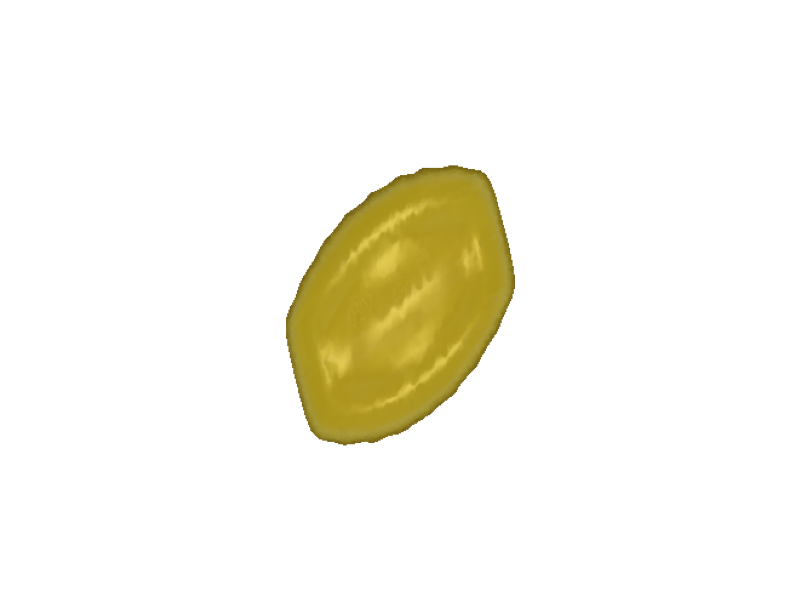

In [5]:
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off")